

# A gentle introduction to machine learning

## Session overview

In this session, we'll go through basic tools of machine learning. We'll cover traditional methods like *PCA*, and more modern ones like *Autoencoders*. We'll cover the basic uses of ML tools: *Dimensionality Reduction, Classification, Generative methods.*

By the end of this session, you will be able to:

1) Load and manipulate standard datasets, namely *MNIST*, which is a good starting point for many applications.

2) Build and fit a *PCA* model.

3) Build and fit an *Autoencoder* model.

4) Learn how to do *Dimensionality Reduction* with *PCA* and *Autoencoders*.

5) Learn how to do *Classification* with *SVM*.

6) Learn how to use *PCA* and *Autoencoders* for *generative* purposes.

7) Advanced:

  a) Use *TSNE* for High dimensional Embeddings

  b) Use *GPU*s and parallel processing for training neural networks.

  c) Learn about *Variational Autoencoders*.

  d) Learn about *Multimodal data*.

#### Import the needed libraries

Note that google colab allows for free CPU and GPU (with more restricted availablity) runtime. You can change the runtime type from the dropdown menu in the top right and selecting *Change runtime type*. **CPU** is regular CPU for all needed tasks, **T4 GPU** can be used to enhance the speed of training of neural networks (to be discussed in the advanced part). Don't run GPU unless you need it, as it'll disconnect often.

If your notebook started in the T4 GPU, change the runtime to CPU, so that you save the GPU for when it's needed.


In [1]:
# Import Numpy and Matplotlib for general use
import numpy as np
import matplotlib.pyplot as plt

# Import PyTorch and its related notebooks for deep learning
import torch # PyTorch library
import torchvision # Assisting library
import torchvision.transforms as transforms # Used to modify the dataset
import torch.nn as nn # The neural networks part of PyTorch
import torch.nn.functional as F # For the activation functions part of PyTorch
import torch.optim as optim # The optimizer used to train the networks

# Import needed functions from sklearn library (we can import a lot of classification and reduction methods from SKLearn)
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE

#### Load MNIST dataset from the assiting library torchvision and put it in useful shape

The MNIST dataset is a well-known benchmark in the field of machine learning and computer vision. It's considered the "hello world" dataset of all that field. It consists of 70,000 grayscale images of handwritten digits from 0 to 9, each of size 28x28 pixels. The dataset is divided into 60,000 training images and 10,000 testing images. Each image is labeled with the corresponding digit, making it an ideal dataset for tasks such as classification, dimensionality reduction, and generative modeling (we will touch upon all of them).



In [2]:
# Load MNIST dataset, it has 60000 train images, and 10000 test ones, accompanied by their true labels
# While we can load the data in an easier way (for example from csv file), this way is useful for neural networks

transform = transforms.ToTensor() # We're making a transformation object that we can apply to our data to normalize it between 0 and 1.
# We can add more transforms using transforms.Compose([transformation 1, 2,
# ...]), for example we can normalize + making RGB to greyscale + zoom in or out + ....

# Here we download the train data by setting train=True and test data by setting train=False
# We also apply our transformation "transform"
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Now we make the data into an object called dataloader, which allows the images and their labels to be called one by one or in certain batchsizes
# Here we want to have all the data in one batch, that's why we set batch_size=len(trainset), which is number of train samples (same for test)
# If we're training a network for example on minibatches (will discuss later), we choose a smaller number (e.g, 128 samples per batch)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

# Convert to numpy arrays, we do so by allowing the loader to be iterated through (using iter) then going to the next element (using next)
# For train data:
images, labels = next(iter(trainloader))

# We make the images and labels numpy arrays (eaiser to deal with, instead of tensors, which would be useful for neural nets later)
# Hover over images (or use the command images.shape), it'll tell you that images is a tensor of size [60000, 1, 28, 28]
# 60000 is number of train samples, 1 is the image, 28x28 are pixels (that gives us a 28x28=784 dimensional vector).
# We want to unpack it into a 60000 x 784 array (number of samples x dimensionality of the image)
X = images.view(images.shape[0], -1).numpy() # We reshape the images as needed, then make the tensor a numpy array
y = labels.numpy() # labels are alreay in shape, we just make them numpy arrays

# For test data:
images_test, labels_test = next(iter(testloader))
X_test = images_test.view(images_test.shape[0], -1).numpy()
y_test = labels_test.numpy()


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.58MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Since the dataset is quite large for this session (but not in general, some of the new AI models are trained on billions of samples),
# we'll trim it a little bit. If you want to revisit this and you have time, just comment the following few lines and you're good to go.
X = X[:10000]
y = y[:10000]
X_test = X_test[:1000]
y_test = y_test[:1000]

**Let's visualize some numbers!**

The true label is 7


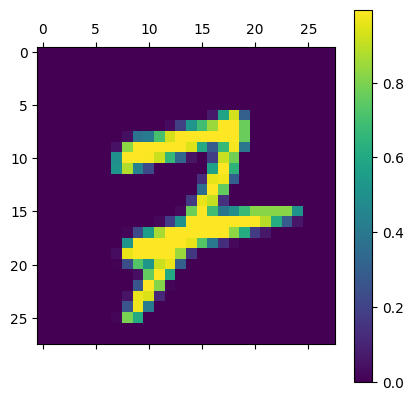

In [4]:
idx = 2 # Choose a number between 0 and 9999 to visualize a number
plt.matshow(X[idx,:].reshape(28,28)) # We pick up the corresponding image and reshape it into a matrix again of size 28x28
plt.colorbar(); # We add a colorbar
print('The true label is '+str(y[idx])) # We get the corresponding label, check if they match (they should, this is the raw data)

### **PCA!**

Now that we have our dataset in the desired shape (number of samples x number of dimensions), we notice that the dimensionality is large, and we don't need all those pixels to know the identity of the digit. In fact, one value should be suffcient, which is the identity of the digit. Let's see what PCA can do to us.

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that transforms the original data into a new coordinate system. The main goal of PCA is to find the directions (principal components) that maximize the variance in the data. Mathematically, given a data matrix $X \in \mathbb{R}^{n \times d}$, PCA seeks to find a projection matrix $W \in \mathbb{R}^{d \times k}$ such that the transformed data $Z = XW$ retains the most significant features of the original data. The principal components are obtained by solving the eigenvalue problem for the covariance matrix of $X$. The eigenvectors corresponding to the largest eigenvalues form the columns of $W$, and $k$ is the number of principal components chosen to represent the data in a lower-dimensional space.



In [5]:
# Perform PCA
pca = PCA(n_components=784) # Create a PCA instant (pca), we decide how many dimensions we want to keep, we can go from 1, all the way up to 784
# If we choose 784, we keep all the dimensions, we effectively did a rotation.
X_pca = pca.fit_transform(X) # We simply fit the data X (PCA is agnostic to the label y), then transform our X into a new variable X_pca.
# It can take a minute depending on how many dims we keep
# the pca instant can be used to train a fit only (using pca.fit(X)) then transform (using pca.transform)
# Now we have a trained object "pca" that we can do many things with (we can access its attributes using pca."attribute")

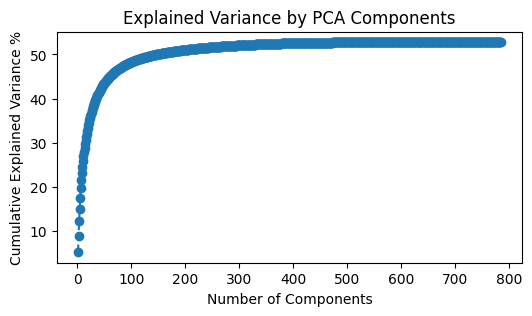

In [6]:
# Plot explained variance as cumulative sum (variance of 1st, variance of 1st+2nd, etc)
plt.figure(figsize=(6, 3))
plt.plot(np.arange(1,pca.n_components_+1), pca.explained_variance_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance %')
plt.title('Explained Variance by PCA Components')
plt.show();

**What can we do with low demensional spaces?**

The first thing we can do is visualization. For example, we can train a PCA instance with only 2 components, then plot them as a scatter plot colored by the true labels to see if we can differentiate between the digits. Visualization becomes more complicated beyond 2D, and if we need to do so, we can use another embedding method that reduces higher dimensionality to 2D, such as t-SNE (check the advanced section at the end of the notebook).

**Visualization with scatter plots**

Note that visualization can be limited in the information we obtain from it, as it doesn't provide numerical data, for example. In the following plot, we can see clusters for 0, 1, 2, and 3. The other numbers are mixed together. This means that if we run a classification or any other type of task based on these embeddings, the task won't differentiate between 4 and 9, for example.

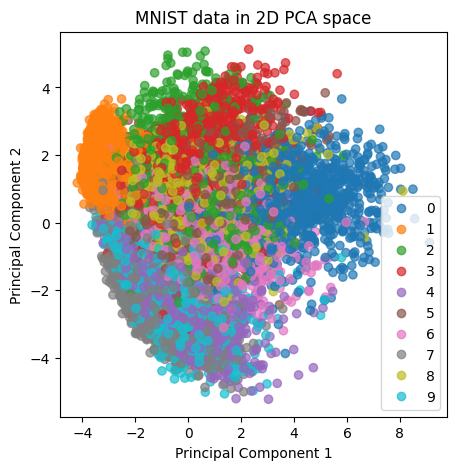

In [7]:
# Truncate to 2 components for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

# Visualize the first 2 principal components
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST data in 2D PCA space')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.show()


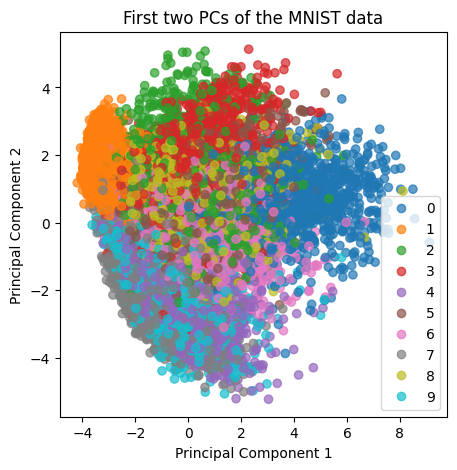

In [8]:
# We can also plot the first 2 components of the original trained PCA.
# We notice that the two plots are almost identical. This is because PCA is implemented with an iterative algorithm called NIPALS.
# It works by finding the first component that explains the most variance, then projecting the data onto that component, and subtracting its contribution
# from the original data, then doing the same for the next component. This means that if we kept 100 components and plotted the first two, it’s
# the same as if we kept the first two components only, which is advantageous if we have finite computational resources.

plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs of the MNIST data')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.show()


**Classification in low dimensional spaces**

Classification is one of the tasks where we can obtain a quantitative result about our reduction process. Classification works by training a classifier—in this case, a Linear Support Vector Machine (SVM)—to learn what the optimal separating hyperplane is between the clusters given their labels. An SVM is a supervised machine learning model that aims to find the best boundary (hyperplane) that separates different classes in the feature space. Mathematically, given a set of training examples $\{(x_i, y_i)\}_{i=1}^n$ where $x_i \in \mathbb{R}^d$ and $y_i \in \{-1, 1\}$, where $+1$ means that this sample is correctly in the cluster, and $-1$ means it's not, an SVM solves the following optimization problem:

$$
\min_{w, b} \frac{1}{2} \|w\|^2 \quad \text{subject to} \quad y_i (w^T x_i + b) \geq 1 \quad \forall i
$$

Here, $w$ is the normal vector to the hyperplane, and $b$ is the bias term. The solution to this problem gives us the hyperplane that maximizes the margin between the two classes. This means we would have 100% accuracy if the classifier draws perfect lines that place each cluster in its own region without mixing.







In [9]:
# SVM classification
# Fit on the whole train dataset
# Here I set max_iter=100, which is the maximum amount we let the solver tries to find the best plane.
# However, this is usually not enough, at least a 1000 or 5000 iterations should be allowed, but this is only for the sake of time.
svm = LinearSVC(max_iter=100)
svm.fit(X_pca, y);

In [10]:
# Predict and evaluate accuracy on 1000 samples of this train dataset
accuracy = svm.score(X_pca[:1000,:], y[:1000])
print(f'SVM classification accuracy with PCA features of the train data: {accuracy*100:.2f}%')

SVM classification accuracy with PCA features of the train data: 96.50%


**Overfitting**

In machine learning, overfitting is a curse you'll have to deal with all the time. It basically means that your method (whether it be dimensionality reduction, classification, etc.) has learned the data so well that it memorized it. This means if you show it an additional sample that it wasn't trained on, it will behave poorly. That's why we should always keep a part of our data dedicated for testing (in fact, we usually keep two parts, one for validation and one for testing. Validation is explained in the advanced section at the end). If we notice that the difference between train and test results is not large, then we call this good training; if it's large, we need to check what we did wrong (of course, words like "large" and "good" are dependant on the task at hand). Sometimes, the simplest method is the most effective one, and adding more complexity can hurt your analysis rather than advance it.

In [11]:
# Predict and evaluate accuracy on test data

# Get X_pca for test data
# Remember we already have a trained PCA (pca) that we can use to reduce more data that wasn't trained on before
X_pca_test = pca.transform(X_test)

# Predict and evaluate accuracy on the test data using the trained classifier (svm)
accuracy_test_pca = svm.score(X_pca_test[:1000,:], y_test[:1000])
print(f'SVM classification accuracy with PCA features of the test data: {accuracy_test_pca*100:.2f}%')


SVM classification accuracy with PCA features of the test data: 89.40%


**The effect of number of components on the accuracy**

PCA is a linear method, which means that whatever we do, we won't get more accuracy beyond a certain level. Let's check what this level is.


In [12]:
# Define the number of components list to keep:
n_components_lst = np.logspace(0, 9, 10, base=2).astype(int) # log space from 1 to 512 component, and keeping them as integers
# Will take some time, try smaller arrays if you want

# Define the empty arrays to keep the results in:
train_accuracy_pca = np.zeros(len(n_components_lst))
test_accuracy_pca = np.zeros(len(n_components_lst))

for i in range(len(n_components_lst)):
  # print the number of components we're using to keep track
  print('Number of components to keep: ',n_components_lst[i])
  # Perform PCA and transform on train, then transform test
  pca = PCA(n_components=n_components_lst[i])
  X_pca = pca.fit_transform(X)
  X_pca_test = pca.transform(X_test)

  # Fit on the whole train dataset
  svm = LinearSVC(max_iter=100)
  svm.fit(X_pca, y);

  # Predict and evaluate accuracy on 1000 samples of the train
  train_accuracy_pca[i] = svm.score(X_pca[:1000,:], y[:1000])

  # Predict and evaluate accuracy on 1000 samples of the test
  test_accuracy_pca[i] = svm.score(X_pca_test[:1000,:], y_test[:1000])

Number of components to keep:  1
Number of components to keep:  2
Number of components to keep:  4
Number of components to keep:  8
Number of components to keep:  16
Number of components to keep:  32
Number of components to keep:  64
Number of components to keep:  128
Number of components to keep:  256
Number of components to keep:  512


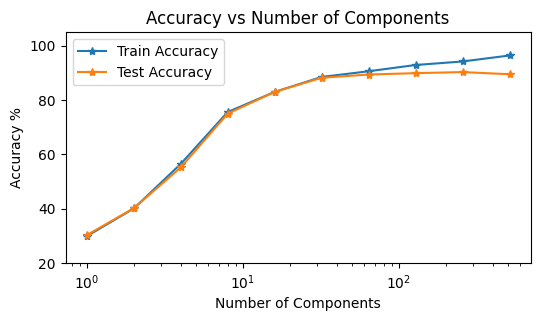

In [13]:
# Plotting the train and test accuracy vs number of kept components
plt.figure(figsize=(6, 3))
plt.plot(n_components_lst, train_accuracy_pca*100, '*-', label='Train Accuracy')
plt.plot(n_components_lst, test_accuracy_pca*100, '*-', label='Test Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs Number of Components')
plt.xscale('log')
plt.ylim(20,105)
plt.legend()
plt.show();

**Reconstruction/Generation**

Having a PCA object means that we have learned the weights $W$ that we can use to get the low-dimensional $Z$ from the data $X$ via $Z = XW$. It also means that if we have a low-dimensional $Z$, we can get the reconstructed $X$ (let's call it $\tilde{X}$) as $\tilde{X} = Z W^{-1}$. The new $\tilde{X}$ contains the information preserved in $Z$, so if we have obtained a good $Z$ that retains our information (the digit identity in this case), we will have $\tilde{X}$ that is close to the original $X$.


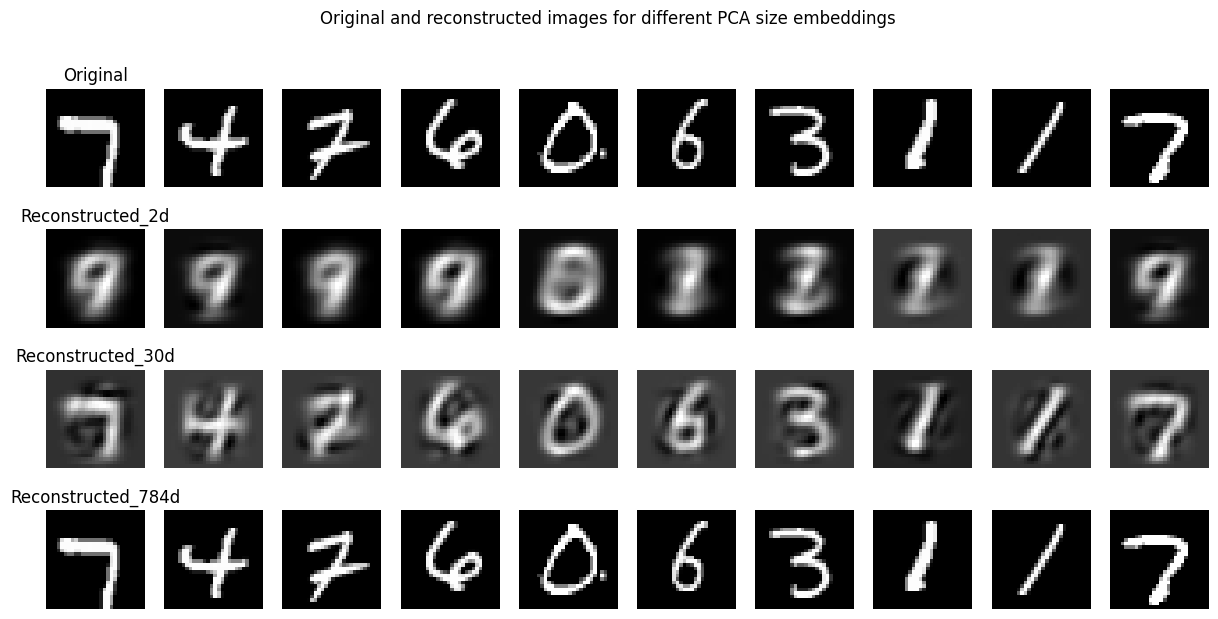

In [14]:
# Reconstruct images from PCA
# Let's visualize two situations, the PCA with 2d that we trained before, and another one with higher number of components
X_reconstructed_2d = pca_2d.inverse_transform(X_pca_2d)


# We notice from the traing and testing curve that a 30d PCA is good enough
# train another 30d pca instant
pca_30d = PCA(n_components=30)

X_pca_30d = pca_30d.fit_transform(X)
X_reconstructed_30d = pca_30d.inverse_transform(X_pca_30d)

# When we are at 784 dimensions (original size), we should be able to get almost (due to data processing inequality) a perfect reconstruction
# train another 784d pca instant
pca_784d = PCA(n_components=784)

X_pca_784d = pca_784d.fit_transform(X)
X_reconstructed_784d = pca_784d.inverse_transform(X_pca_784d)


# Plot original and reconstructed images
fig, axes = plt.subplots(4, 10, figsize=(15, 7))
fig.suptitle('Original and reconstructed images for different PCA size embeddings')
for i in range(10):
    axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
    axes[1, i].imshow(X_reconstructed_2d[i,:].reshape(28,28), cmap='gray')
    axes[2, i].imshow(X_reconstructed_30d[i,:].reshape(28,28), cmap='gray')
    axes[3, i].imshow(X_reconstructed_784d[i,:].reshape(28,28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
    axes[3, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed_2d')
axes[2, 0].set_title('Reconstructed_30d')
axes[3, 0].set_title('Reconstructed_784d')
plt.show();

### **Neural Networks and whatnot**

Neural networks are universal approximators; they can approximate any continuous nonlinear function (given enough layers, width, training, etc.).

In the context of the language we used for PCA, if PCA is finding $W$ that maximizes the variance explained by $Z$ in $Z = XW$ (which means that $Z$ is just a linear function of $X$, that's why we call PCA a linear dimensionality reduction method), then its neural network equivalent would be an *Autoencoder*, in which a neural network is finding a function $g$ such that $Z = g(X)$, where $g$ is potentially any nonlinear function.

**What's a neural network**

A neural network is composed of multiple neurons, which are the basic units of computation. Each neuron receives inputs, applies a linear transformation followed by a nonlinear activation function, and produces an output. Mathematically, a neuron can be described as:

$$
a = \sigma(Wx + b)
$$

where $x$ is the input vector, $W$ is the weight vector, $b$ is the bias, and $\sigma$ is the activation function (e.g., ReLU, sigmoid, tanh).

Neurons are organized into layers. A layer consists of multiple neurons, and the outputs of one layer become the inputs to the next layer. By stacking layers together, we form a neural network that can model complex relationships between inputs and outputs.

Training a neural network involves adjusting the weights and biases using an optimization algorithm. Stochastic Gradient Descent (SGD) is one such algorithm. It works by iteratively updating the weights and biases to minimize a loss function, which measures the difference between the network's predictions and the actual target values. The update rule for weights $W$ using SGD is given by:

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}
$$

where $\eta$ is the learning rate and $\frac{\partial L}{\partial W}$ is the gradient of the loss function $L$ with respect to the weights $W$.

**Back to Autoencoders**

Autoencoders are a type of neural network designed to learn efficient representations of data, typically for the purpose of dimensionality reduction or feature learning. An autoencoder consists of two main parts: an encoder and a decoder. The encoder compresses the input data into a lower-dimensional representation, while the decoder reconstructs the original data from this compressed representation.

The loss function used in autoencoders is typically the reconstruction loss, which measures the difference between the original data and the reconstructed data. A common choice for this loss function is the Mean Squared Error (MSE), defined as:

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^N ||x_i - \tilde{x}_i||^2
$$

where $x_i$ is the original data, $\tilde{x}_i$ is the reconstructed data, and $n$ is the number of samples. The goal during training is to minimize this reconstruction loss, thereby ensuring that the learned representation captures the important features of the data.

Autoencoders resemble PCA in that both techniques aim to reduce the dimensionality of the data while preserving as much of the relevant information as possible. However, while PCA is a linear method that finds the principal components based on variance, autoencoders can learn complex, nonlinear mappings from the data to a lower-dimensional space. Thus, autoencoders are more flexible and can capture more intricate patterns in the data compared to PCA.


**Do you wanna build an autoencoder?**

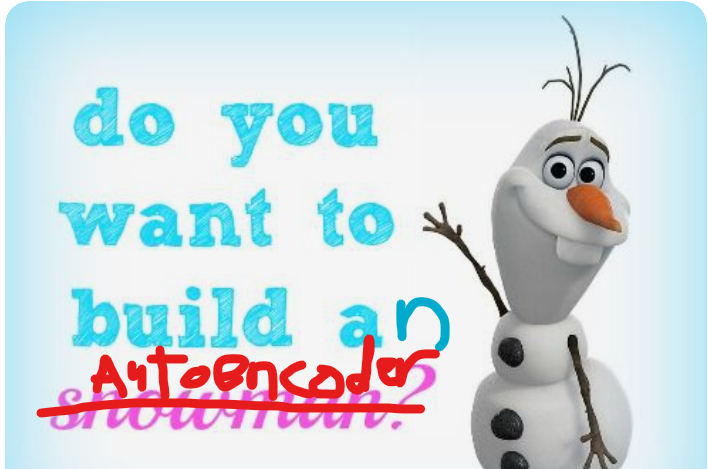

An autoencoder is made up of an encoder and a decoder. The encoder is a sequence of layers that takes $X$ with the original dimensionality of the data (784 in our case) and embeds it in a lower-dimensional space of certain dimensionality (denoted as $dz$ in this context—similar to $n_{\text{components}}$ in PCA, where $dz$ is the dimensionality of the low-dimensional variable $Z$, also called the bottleneck size).

The decoder is another network that takes this low-dimensional representation $Z$ and tries to reconstruct $X$ from it, producing the reconstructed $X$, or $\tilde{X}$. We then want the network to find the best weights and biases that make our $X$ and $\tilde{X}$ as close to each other as possible.


**Few CS Jargons**

In Python, a class is a blueprint for creating objects (instances). A class defines a set of attributes and methods that the created objects can use. The *\_\_init\_\_* method, also known as the constructor, is a special method that is called when an object is instantiated from the class. It initializes the object's attributes and sets the initial state.

Here is an example of a neural network encoder class:


In [7]:
# We build a class called encoder. This class takes two inputs, size of the bottleneck, and the original input size of the data
# All of the following is done within PyTorch library. Other libraries like Tensorflow, Keras, Theano, would have similiar-ish structure
# but with different synatx. However, the key idea is the same
class encoder(nn.Module):
    def __init__(self, dz, input_dim=784): # The __init__ method initializes the class with default and specified values
    # if we put a number here (input_dim=784) for example, it means that this is the default value
        super(encoder, self).__init__() # Calls the constructor of the parent class nn.Module
        self.dz=dz # we specify the variables that we can call again later
        self.dense1=nn.Linear(input_dim,1024) # First dense layer that takes input_dim (784 by default) and embeds it in a hidden layer of size 1024
        self.dense2=nn.Linear(1024,1024) # Second dense layer that maps the 1024-dimensional input to another 1024-dimensional space
        self.dense3=nn.Linear(1024,dz)  # Third dense layer that takes the input from the hidden layer and passes it to the final output of size dz

    def forward(self, data): # the forward function specifies how do you want the data to be passed, it takes an input data
        x = F.relu(self.dense1(data)) # here we passed the data through the first dense layer, and we apply a relu activation function
        x = F.relu(self.dense2(x)) # we take our embedded data through the first layer then pass it to the second, with relu activiation as well
        x = self.dense3(x) # we take our embedded data through the second layer then pass it to the third
        return x

In this example, we define an encoder class that inherits from *nn.Module*. The *\_\_init\_\_* method initializes the layers and parameters of the encoder, and the *forward* method defines how the data is passed through the network.

In [8]:
# We build a class called decoder. This class takes two inputs, size of the bottleneck, and the original output (same as input) size of the data
class decoder(nn.Module):
    def __init__(self,dz,output_dim=784):
        super(decoder, self).__init__()
        self.dz=dz
        self.dense1=nn.Linear(dz,1024)
        self.dense2=nn.Linear(1024,1024)
        self.dense3=nn.Linear(1024,output_dim)
    def forward(self, Z):
        x = F.relu(self.dense1(Z))
        x = F.relu(self.dense2(x))
        x = F.sigmoid(self.dense3(x))
        # we have a sigmoid activiation function here to allow the values to be bounded between 0 and 1, like the original data X
        return x


# Now we build a class thats called AE (Autoencoder), it bascially calls the encoder and decoder, passes the data between them, and defines
# how to compute the mean square error loss
# It takes two inputs, size of the bottleneck, and the original input size of the data
class AE(nn.Module):
    def __init__(self,input_dim=784,dz=2):
        super(AE, self).__init__()

        self.Xencode=encoder(dz=dz, input_dim=input_dim) # Here we call the encoder with appropriate dimensionalities

        self.Xdecode=decoder(output_dim=input_dim,dz=dz) # Here we call the decoder with appropriate dimensionalities

    def forward(self, X): # We specify how the data is passed in our network, we start by input data X
        Z=self.Xencode(X) # We take a batch of the data X, pass it through the encoder to get the low dim representation Z

        rec_X=self.Xdecode(Z) # We take the low dim representation Z and pass it through the decoder to get the reconstructed X

        loss=torch.mean(torch.sum(-.5*torch.square(X-rec_X),dim=1)) # the loss function is simply the mean square error between X and rec_X

        return loss

AE(
  (Xencode): encoder(
    (dense1): Linear(in_features=784, out_features=1024, bias=True)
    (dense2): Linear(in_features=1024, out_features=1024, bias=True)
    (dense3): Linear(in_features=1024, out_features=10, bias=True)
  )
  (Xdecode): decoder(
    (dense1): Linear(in_features=10, out_features=1024, bias=True)
    (dense2): Linear(in_features=1024, out_features=1024, bias=True)
    (dense3): Linear(in_features=1024, out_features=784, bias=True)
  )
)
tensor([[ 0.0269, -0.0289, -0.0226,  ...,  0.0291, -0.0132,  0.0071],
        [ 0.0089, -0.0191, -0.0269,  ..., -0.0047,  0.0009,  0.0341],
        [-0.0263,  0.0225, -0.0187,  ...,  0.0085,  0.0263,  0.0278],
        ...,
        [-0.0299, -0.0070,  0.0229,  ..., -0.0079, -0.0189, -0.0196],
        [-0.0254,  0.0046, -0.0002,  ..., -0.0229,  0.0004,  0.0295],
        [-0.0329, -0.0072,  0.0179,  ...,  0.0297,  0.0132,  0.0260]])


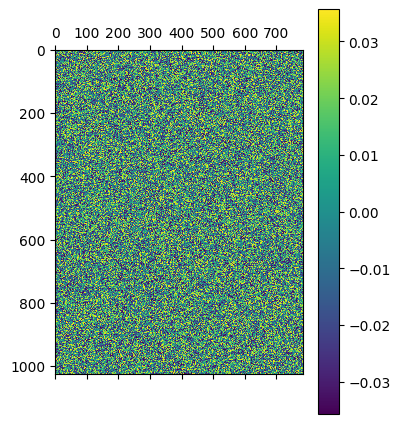

torch.Size([1024, 784])


In [17]:
# Now we can simply run the class AE, to produce a network that we can train it
autoencoder = AE(input_dim=784,dz=10) # Specify dz

# investigate autoencoder, it should have the endcoder and decoder with correct dimensionalities and hidden layers
print(autoencoder)

# You can get the initial weights of such layers in such network, our task is to train them to find their best values
print(autoencoder.Xencode.dense1.weight.data)
# You can visualize it as well, it's a random matrix
plt.matshow(autoencoder.Xencode.dense1.weight.data)
plt.colorbar();
plt.show();

# check the size of the weights of this layer. It is the size of inputx1024 which is the size of the hidden layer
print(autoencoder.Xencode.dense1.weight.data.shape)


In [18]:
# Now let's build a function that takes the untrained network and trains it
def trainAE(autoencoder, data, epochs=20):
    """
    Function to train the autoencoder.
    Args:
      autoencoder: The untrained network
      data: The dataloader used in training
      epochs: The number of epochs we want to train the network for. An epoch is a training round in which the network has seen all the samples once

    Returns: A trained network
    """
    opt = torch.optim.Adam(autoencoder.parameters()) # we define an optimizer. Adam is an adapitve Stochastic Gradient descent optimizer.
    # Simply put, it's an algorithm that searches for the best weights that give the best minima in the loss function we defined
    # We tell this optimizer that you should train the parameters of our autoencoder network that we'll give you as an input
    # we can add multiple parameters here as well, and fine tune learning rates, momentum, etc. (check the documentation of Adam)
    for epoch in range(epochs): # we loop over the epochs
        for i, x in enumerate(data): # We go through the data batches from the dataloader
            img, _ = x # Get the image without the label part
            img = img.view(img.size(0), -1) # reshape it so that it's batchsize x 784
            opt.zero_grad() # We start by zeroing all the gradients, initilaizing the optimizer
            loss = -autoencoder(img) # We pass the batch through the network, which gives us the loss value (mse between X and rec_X)
            # Note that the loss has negative value in front of it.
            loss.backward() # We backpropagate the loss value to the network
            opt.step() # We move forward one step with the optimizer to do this process again

        print(f'epoch [{epoch+1}/{epochs}], loss:{loss.item():.4f}') # We print the loss value every epoch

    return autoencoder # We return the trained newtork


In [10]:
# Now we're ready to train the network. We just need to remake our trainloader
# into an object that gives us a batch (of size 128) instead of the whole dataset
# Again, this will take a lot of time, so let's create a smaller dataset using Subset function from the utilities of pytorch.
# Note that Neural networks are always data hungry, if you have a small number of samples, they're likely not going to give you good results
# Unless you're very careful and built the minimal network, and even then you might not be able to do it.

# Create a subset of the dataset containing the first 10,000 samples
subset_indices = list(range(10000))
trainset_subset = torch.utils.data.Subset(trainset, subset_indices)

trainloader_nn = torch.utils.data.DataLoader(trainset_subset, batch_size=128, shuffle=True)

In [20]:
# Lets define our network for 2d and 10d
autoencoder_2d = AE(input_dim=784,dz=2) # Specify dz
autoencoder_10d = AE(input_dim=784,dz=10) # Specify dz

# Now we train the network for 5 epochs, notice that it'll take time
autoencoder_2d = trainAE(autoencoder=autoencoder_2d, data=trainloader_nn, epochs=5)
autoencoder_10d = trainAE(autoencoder=autoencoder_10d, data=trainloader_nn, epochs=5)

epoch [1/5], loss:20.2604
epoch [2/5], loss:20.6914
epoch [3/5], loss:17.9699
epoch [4/5], loss:18.6694
epoch [5/5], loss:19.3349
epoch [1/5], loss:19.9827
epoch [2/5], loss:11.8308
epoch [3/5], loss:11.7161
epoch [4/5], loss:8.5874
epoch [5/5], loss:6.7742


In [21]:
# Evaluate the autoencoder, we can use the same procedure we did with PCA
# We have a trained autoencoder object, that we can use its encoder to produce latent spaces, and its decoder to reconstruct images
# Let's obtain low dimensional spaces Z from X train and test and their corresponding reconstructions
# Here we use torch.Tensor to make our numpy image arrays into tensors that can be passed to the network
# Then we use .detach().numpy() to get it back to numpy to visualize and classify

# Encoding
Z_2d = autoencoder_2d.Xencode(torch.Tensor(X))
Z_10d = autoencoder_10d.Xencode(torch.Tensor(X))

# Decoding
X_rec_nn_2d = autoencoder_2d.Xdecode(Z_2d).detach().numpy()
X_rec_nn_10d = autoencoder_10d.Xdecode(Z_10d).detach().numpy()

# Encoding back to numpy
Z_2d = Z_2d.detach().numpy()
Z_10d = Z_10d.detach().numpy()

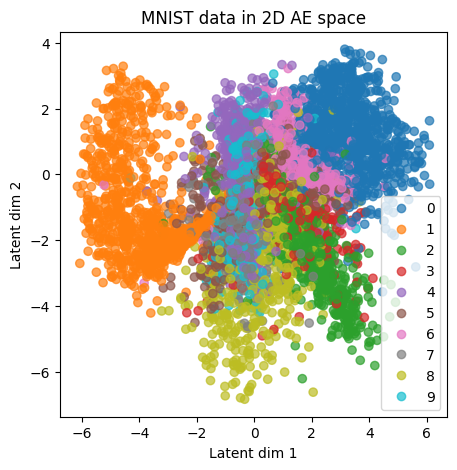

In [22]:
# Visualize the 2 latent dimensions from 2d
# We notice a nice separation of the clusters of 0,1,2,6,7 and not so great separation for the others. However, it seems more
# separated than PCA, even at 2d bottleneck.
plt.figure(figsize=(5, 5))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.title('MNIST data in 2D AE space')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.show()


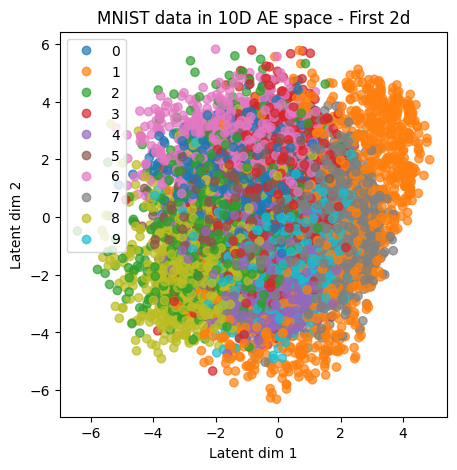

In [23]:
# Visualize the first 2 latent dimensions from 10d
# While AEs and PCA share similarities, they are not the same. For instance, if we train AE with 10d bottleneck, we won't have the first
# 2d carrying the most "variance" as before, and information is spread among all the dimensions.
# This is a general problem with neural network based methods, the interpretability is harder.
plt.figure(figsize=(5, 5))
scatter = plt.scatter(Z_10d[:, 0], Z_10d[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.title('MNIST data in 10D AE space - First 2d')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.show()


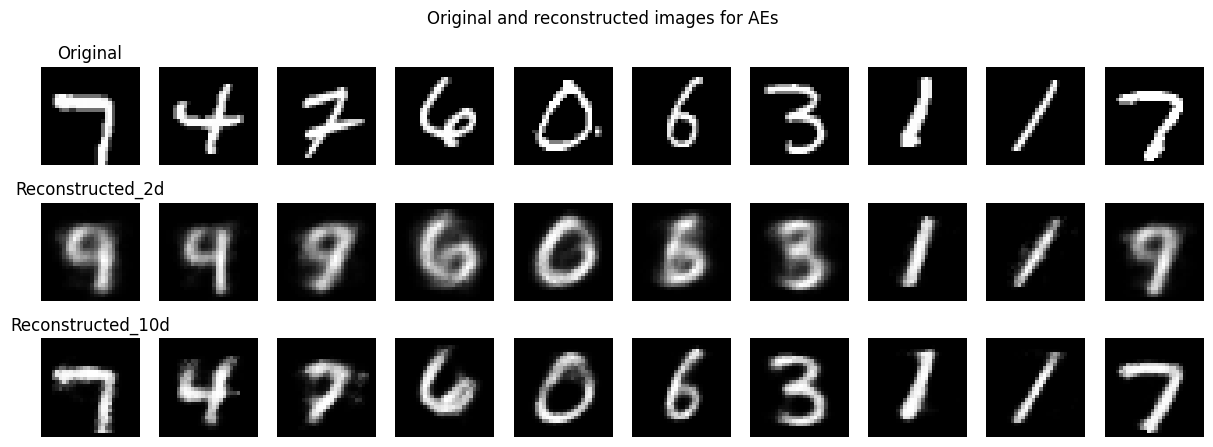

In [24]:
# Plot original and reconstructed images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
fig.suptitle('Original and reconstructed images for AEs')
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[1, i].imshow(X_rec_nn_2d[i,:].reshape(28,28), cmap='gray')
    axes[2, i].imshow(X_rec_nn_10d[i,:].reshape(28,28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed_2d')
axes[2, 0].set_title('Reconstructed_10d')
plt.show();

In [25]:
# SVM classification
# Fit on the whole train dataset
svm_nn_10d = LinearSVC(max_iter=100)
svm_nn_10d.fit(Z_10d, y);

In [26]:
# Predict and evaluate accuracy on 1000 samples of this train dataset
accuracy = svm_nn_10d.score(Z_10d[:1000,:], y[:1000])
print(f'SVM classification accuracy with AE latent space of the train data: {accuracy*100:.2f}%')

# Predict and evaluate accuracy on the test data using the trained classifier (svm)
# Get the test Z_test_10d first:
Z_test_10d = autoencoder_10d.Xencode(torch.Tensor(X_test))
Z_test_10d = Z_test_10d.detach().numpy()

accuracy_test = svm_nn_10d.score(Z_test_10d[:1000,:], y_test[:1000])
print(f'SVM classification accuracy with AE latent space of the test data: {accuracy_test*100:.2f}%')

# We notice that at 10d, we're getting comperable accuracy to PCA's maximum number of dimensions. This is because the infromation
# "identity of the digit" is not spread in a linear fashion, and AEs are more suited in capturing nonlinear relations than PCA.
# Albeit with the cost of more computational power, and harder interpretablity, giving neural nets methods the correct tag of being black-boxes.

SVM classification accuracy with AE latent space of the train data: 84.70%
SVM classification accuracy with AE latent space of the test data: 82.40%


While we can (and we should) follow the same procedure that we did for PCA (using train and test subsets to check for overfitting, varying the number of dimensions $dz$ in the bottleneck, etc.), some of these steps are quite advanced and might require additional experience with PyTorch and Python in general. In the next section, we cover some of these aspects and others.

### **Do it yourself!**

**Replicate the Analysis on the FashionMNIST Dataset**

Now that you've worked through PCA and Autoencoders on the MNIST dataset, try to apply the same techniques on the FashionMNIST dataset. FashionMNIST has the same structure as MNIST, with 28x28 grayscale images, but the images represent different types of clothing items.

Your task is to:

*PCA*

1. Reduce the dimensionality of the FashionMNIST dataset.
2. Visualize the first two principal components.
3. Classify the images using a linear classifier (e.g., SVM) in the reduced space.


*Autoencoders*

1. Create an autoencoder for the FashionMNIST dataset.
2. Train the autoencoder and visualize the reconstructed images.
3. Classify the images using the encoded representations.
4. Use the trained autoencoder to generate new images by sampling from the latent space.

In [ ]:
# Use the following code as a start
# Maybe you want to create a fresh notebook for that, then you don't need to change the names of the labels

# Define the transformation to apply to the data:
transform_fashion = # Write your transformation

# Load the FashionMNIST dataset:
trainset_fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
subset_indices_fashion = list(range(10000))  # Use only the first 10,000 samples
trainset_subset_fashion = torch.utils.data.Subset(trainset, subset_indices)
trainloader_nn_fashion = torch.utils.data.DataLoader(trainset_subset, batch_size=128, shuffle=True)

# Make the data into X and y for both train and test (note that because we already used subset of the data we don't need to use X[:10000,:]):


In [ ]:
# PCA

# Perform PCA:
pca_fashion = # Write PCA code

In [ ]:
# Visualize PCA results
# Write code to visualize PCA results:


In [ ]:
# Use PCA embeddings for classification
# Train a linear classifier on the PCA data:


In [ ]:
# Autoencoder

# Define the Encoder class (if you want, you can use the previous one, or you can play with your own):
class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()

    def forward(self, data):
        return

# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

    def forward(self, data):
        return

# Define the AE class:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

    def forward(self, data):
        return


In [ ]:
# Define a training function:
def trainAE(autoencoder, data, epochs=20):
  # define an optimizer
  # ....



In [ ]:
# Create autoencoder instance:
autoencoder = AE() # Fill in

In [ ]:
# Train the autoencoder:
autoencoder = trainAE(autoencoder, loader, epochs)


In [ ]:
# Visualize the embeddings
# Embed your data using your trained encoder from the AE:


In [ ]:
# Visualize reconstructed images
# Reconstruct the images using the decoder based on your encoded data from before:

# Visualize the original and reconstructed images:


In [ ]:
# Use encoded representations for classification


### **Advanced sections**

Here are some of the things we mentioned before but are a bit more advanced; you can explore them on your own. Additionally, there are a few other interesting avenues that might intrigue some of you or be useful in future work.


1.   t-SNE Visualizations
2.   GPU training
3.   Variational Autoencoders
4.   Multimodal data
5.   What if you want more?




#### **t-SNE Visualization**

If we want to visualize higher dimensions in 2D, t-SNE is a standard method. You can read its documentation at (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)


In [27]:
# Here we embed the original X data (784 dimensions) to only 2. We can do the same for X_pca, for example.
# Note, this will take some time to run. Try using X_pca instead of X or a fewer number of samples if you don't want to wait.
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

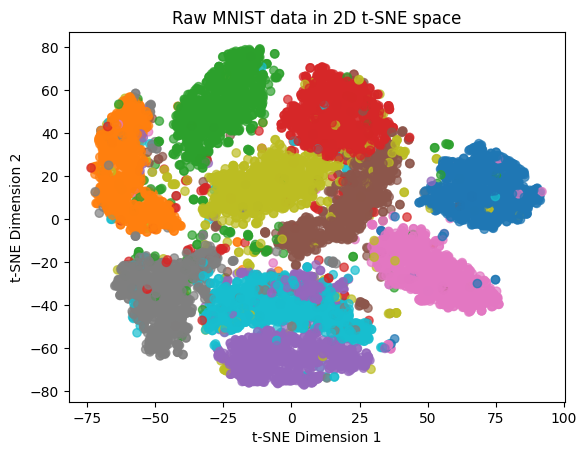

In [28]:
# Plot the tsne as scatter plot
# We see that we have perfect clusters, which is what we hope to see from a good dimensionality reduction method, but without all 784 dimensions
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Raw MNIST data in 2D t-SNE space')
plt.show()

#### **GPU Training**

We noticed that when we train the neural net even for 5 epochs, it took a lot of time. This problem hinders us from checking for multiple $dz$ values, for example. Here is where GPUs come to our aid.

The basic idea behind why GPUs are so good for neural network training (with appropriate libraries, of course) is that they can split the big process into thousands of smaller ones that take significantly less time.

To use a GPU in training, you need to have a machine with NVIDIA GPU capabilities first (not all laptops do). Then, you go through the painful process of installing CUDA and its corresponding toolkit, ensuring they match the NVIDIA version you have, and then you install PyTorch accordingly. Once you do this, you're ready for the next section.

However, there's a workaround: using Google Colab. Colab has GPU training available, and more importantly, it has all the libraries installed in the correct version. However, it has limited available time and disconnects often. So, it might be useful to download and run CUDA if you have the capacity and if you'll rely on GPU training a lot. For now, we'll go with Colab. Remember, if you changed the runtime type, you need to rerun the codes necessary for the following, namely loading the libraries, datasets, and loaders

**Training on GPUs**

To train a model with GPU, we need two things:


1.   The data to be in the GPU
2.   The model to be in the GPU

We usually do so by a simple code *.to(device)*, where device is the GPU device.




In [4]:
# Check if CUDA is running, and define it as "device"
# If running on colab, it should give CPU, unless using the T4 GPU, it should give CUDA
device = 'cuda'
if(not torch.cuda.is_available()):
    device = 'cpu'
print(device)

cuda


In [5]:
# Our training function, revisited
def trainAE(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for i, x in enumerate(data):
            img, _ = x
            img = img.view(img.size(0), -1)
            img = img.to(device) # Pushing the data to the GPU
            opt.zero_grad()
            loss = -autoencoder(img)
            loss.backward()
            opt.step()

        print(f'epoch [{epoch+1}/{epochs}], loss:{loss.item():.4f}')
    return autoencoder

In [11]:
# Model on the GPU
autoencoder_10d = AE(input_dim=784,dz=10).to(device) # Specify dz

# Now we train the network for 20 epochs, notice that it'll take signficantly less time if we have CUDA enabelled
autoencoder_10d = trainAE(autoencoder=autoencoder_10d, data=trainloader_nn, epochs=20)

epoch [1/20], loss:23.7857
epoch [2/20], loss:12.3943
epoch [3/20], loss:9.3929
epoch [4/20], loss:8.4945
epoch [5/20], loss:6.6399
epoch [6/20], loss:8.0118
epoch [7/20], loss:8.8333
epoch [8/20], loss:7.5292
epoch [9/20], loss:6.0863
epoch [10/20], loss:6.0638
epoch [11/20], loss:6.0313
epoch [12/20], loss:6.4965
epoch [13/20], loss:5.3102
epoch [14/20], loss:5.4988
epoch [15/20], loss:5.6823
epoch [16/20], loss:5.4584
epoch [17/20], loss:5.0683
epoch [18/20], loss:5.2193
epoch [19/20], loss:3.6792
epoch [20/20], loss:5.7089


In [13]:
# Then if we want to evaluate, we need to check that the data we pass to our network is also on the GPU
# Encoding
Z_10d = autoencoder_10d.Xencode(torch.Tensor(X).to(device))

# Decoding, no problem as both the model and Z_10d are on the GPU. But we need to take X_rec_nn_10d to CPU from the GPU first to use it afterwards
X_rec_nn_10d = autoencoder_10d.Xdecode(Z_10d).to('cpu').detach().numpy()

# Encoding back to numpy, but we need to take it to the CPU from the GPU first
Z_10d = Z_10d.to('cpu').detach().numpy()

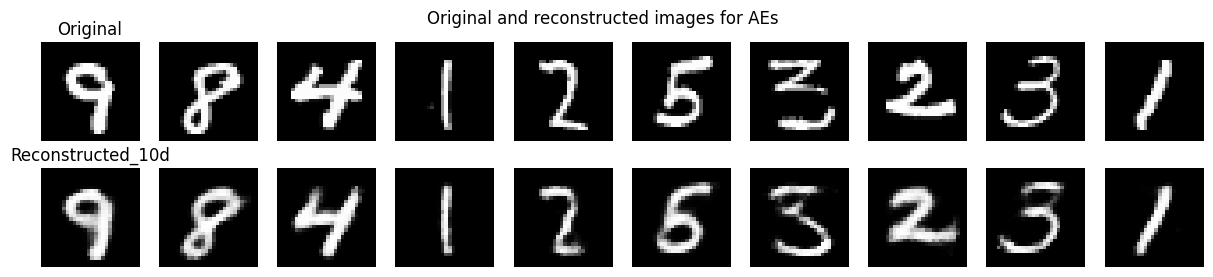

In [14]:
# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Original and reconstructed images for AEs')
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[1, i].imshow(X_rec_nn_10d[i,:].reshape(28,28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed_10d')
plt.show();

#### **Variational Autoencoders**

The autoencoder we just trained has a deterministic mapping between each sample in $X$ and its corresponding $Z$. However, this kind of training can overfit, as it learns how to map each sample exactly. An alternative approach is, instead of learning $Z=g(X)$, we can learn the distribution $p(Z|X)$. The distribution can be learned variationally (usually as a Gaussian) and approximated with a neural network in a similar manner to what we did for regular autoencoders, resulting in what is known as Variational Autoencoders (VAE for short).

Variational methods in general are known to be less susceptible to overfitting because they learn distributions, not deterministic mappings. They also have generative abilities (i.e., the reconstruction can be learned as $q(X|Z)$), which allows the generation of new samples from the learned distributions. This method was introduced and made practical in [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).

As we'll see, the implementation of VAEs is not that different from regular AEs. Instead of embedding to a bottleneck $Z$, we embed to two bottlenecks that learn the means $\mu(Z)$ and variances $\sigma(Z)$ of the distribution (assuming it's a Gaussian, which is usually a valid assumption). Then we can sample from such a distribution.

In [15]:
# Define the new variational encoder, the deocder stays the same
class var_encoder(nn.Module):
    def __init__(self, dz, input_dim=784):
        super(var_encoder, self).__init__()
        self.dz=dz
        self.kl_loss=0.0 # Initiate the KL loss
        self.dense1=nn.Linear(input_dim,1024)
        self.dense2=nn.Linear(1024,1024)
        self.dense3=nn.Linear(1024,dz)
        self.dense4=nn.Linear(1024,dz)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # Get sampling on the GPU if it exists
        self.N.scale = self.N.scale.to(device)

    def forward(self, data):
        x = F.relu(self.dense1(data))
        x = F.relu(self.dense2(x))
        meanz = self.dense3(x)
        logVar = self.dense4(x)
        self.kl_loss = torch.mean(torch.sum(-0.5 * (1 + logVar - torch.square(meanz) - torch.exp(logVar)), dim=1)) # The KL loss after assuming a gaussian
        epsilon = self.N.sample(meanz.shape)
        samples = meanz + torch.exp(0.5 * logVar) * epsilon
        return [meanz, logVar, samples] # return the learnt means, log variances (makes math easier to learn log Var instead of Var), and samples

In [16]:
# Redefine the VAE class
class VAE(nn.Module):
    def __init__(self,input_dim=784,dz=2):
        super(VAE, self).__init__()

        self.Xencode=var_encoder(dz=dz, input_dim=input_dim) # Here we call the encoder with appropriate dimensionalities
        self.Xdecode=decoder(output_dim=input_dim,dz=dz) # Here we call the decoder with appropriate dimensionalities

    def forward(self, X):
        _,_,Z=self.Xencode(X) # Here we obtain samples from the encoder
        rec_X=self.Xdecode(Z)

        loss=self.Xencode.kl_loss-torch.mean(torch.sum(-.5*torch.square(X-rec_X),dim=1)) # The loss function is the KL loss - MSE loss

        return -loss # There's a negative sign as we already have one in the training loop

In [17]:
# The train AE function can be used again, but with VAE network instead of AE
vae_10d = VAE(input_dim=784,dz=10).to(device) # Specify dz

# Now we train the network for 5 epochs
vae_10d = trainAE(autoencoder=vae_10d, data=trainloader_nn, epochs=20)

epoch [1/20], loss:23.3933
epoch [2/20], loss:25.8780
epoch [3/20], loss:20.5684
epoch [4/20], loss:21.8282
epoch [5/20], loss:22.8229
epoch [6/20], loss:21.9360
epoch [7/20], loss:17.3388
epoch [8/20], loss:19.8925
epoch [9/20], loss:17.0652
epoch [10/20], loss:21.6642
epoch [11/20], loss:20.2036
epoch [12/20], loss:21.4609
epoch [13/20], loss:22.8433
epoch [14/20], loss:18.6398
epoch [15/20], loss:20.2536
epoch [16/20], loss:17.5770
epoch [17/20], loss:18.5662
epoch [18/20], loss:19.1255
epoch [19/20], loss:19.9957
epoch [20/20], loss:18.6106


In [18]:
# Similar to AE...
_,_,Z_vae_10d = vae_10d.Xencode(torch.Tensor(X).to(device))
X_rec_nn_vae_10d = vae_10d.Xdecode(Z_vae_10d).to('cpu').detach().numpy()
Z_vae_10d = Z_vae_10d.to('cpu').detach().numpy()

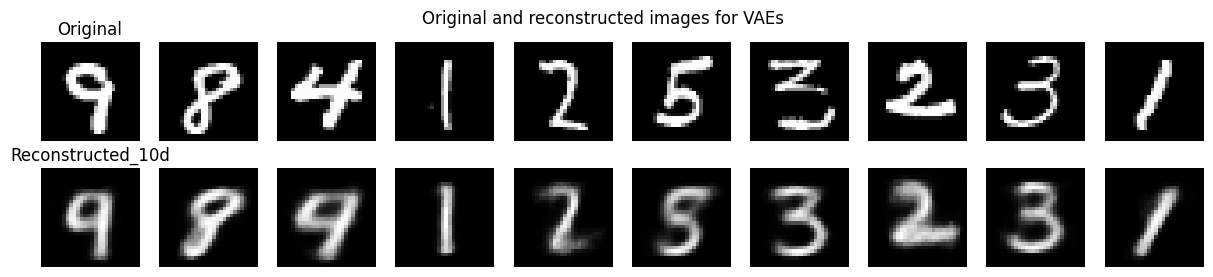

In [19]:
# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Original and reconstructed images for VAEs')
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[1, i].imshow(X_rec_nn_vae_10d[i,:].reshape(28,28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed_10d')
plt.show();

#### **Multimodal Data**

What if instead of having one data source $X$, we have multiple data sources $X_1, X_2$, for example, with a similar shared label $y$? This class of problems is called multimodal or multiview learning. Here, we observe multiple modalities that have a shared low-dimensional representation between them, and our goal is to find out what this shared space is.

An example of such a setup is when we have images and corresponding text descriptions, and we want to classify the images and descriptions based on their category. One could perform PCA on images and text independently, hoping that $Z_{X_1}$ and $Z_{X_2}$ (for images and text, respectively) carry information about the category $y$. However, such *independent reduction* (for each modality independently) can focus on parts of the text or image that are not relevant to the category identity depending on their variance.

We will have a better chance if we include both sources of information, ensuring that the reduced images and text are both relevant to each other, which is more likely to be relevant to the category identity. The multimodal version of PCA in such a case would be either Partial Least Squares (PLS) or Canonical Correlation Analysis (CCA). A comparison of these methods by yours truly can be found [here](https://arxiv.org/abs/2310.04458).

Additionally, if we want to go nonlinear (as we moved from PCA to AEs), the multimodal counterparts would be Deep Variational CCA [(DVCCA)](https://arxiv.org/abs/1610.03454) or Deep Variational Symmetric Information Bottleneck (DVSIB). You can read about these in a study by also yours truly [here](https://arxiv.org/abs/2310.03311).

A simple implementation for CCA and DVCCA is found next.


In [ ]:
# CCA
# Generate a synthetic data X1, X2
X1 = np.random.normal(size=(1000,20))
X2 = np.random.normal(size=(1000,20))

# Import CCA from SKlearn
from sklearn.cross_decomposition import CCA

# Perform CCA on X1 and X2, similar syntax to PCA:
cca = CCA(n_components=2);
cca.fit_transform(X1,X2);

# You know what to do next :)

In [ ]:
# DVCCA
class DVCCA(nn.Module):
    def __init__(self,input_dimx,input_dimy,dz=2):
        super(DVCCA, self).__init__()
        self.ZXencode=var_encoder(dz=dz, input_dim=input_dimx) # one encoder for X (or Y, or both)
        self.Xdecode=decoder(output_dim=input_dimx,dz=dz) # a decoder for X
        self.Ydecode=decoder(output_dim=input_dimy,dz=dz) # another decoder for Y


    def forward(self, X, Y): # Now we take X and Y as inputs
        _,_,Z=self.ZXencode(X)

        rec_X=self.Xdecode(Z)
        rec_Y=self.Ydecode(Z)

        # Total loss is KL loss - (MSE loss for X + MSE loss for Y)
        loss= self.ZXencode.kl_loss - (torch.mean(torch.sum(-.5*torch.square(X-rec_X),dim=1))+torch.mean(torch.sum(-.5*torch.square(Y-rec_Y),dim=1)))

        return loss

def trainDVCCA(dvcca, data, epochs=20):
    opt = torch.optim.Adam(dvcca.parameters())
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU if available, now we load X and Y
            y = y.to(device)
            opt.zero_grad()
            loss = dvcca(x,y)
            loss.backward()
            opt.step()

    return dvcca

# You know how to continue from here too :)

#### **What if you want more?**

Machine Learning (ML) is a rapidly evolving field, with constant updates, especially on the application side. There are many techniques we know how to implement, few we understand fully, and even fewer we comprehend why they work. Most of the time, we know how to make things work, but we may not understand the underlying mechanisms. It's important to be cautious when applying new methods and do our best to avoid using ML as a black box. Instead, start with the simplest methods that we understand well, as these might be sufficient.

Here are a few papers that I think are useful and might help some of you as much as they helped me -- or I had something to do with them :) :

1. [A high-bias, low-variance introduction to Machine Learning for physicists](https://arxiv.org/abs/1803.08823): This is more of a book than a paper. It's a very detailed introduction to almost all the important topics of ML, with language relevant to physicists. It's accompanied by Python notebooks that provide good hands-on experience.

2. [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html): This is one of the best books I've found on the subject. It's focused on applications and brings you up to date with all the different architectures, their caveats, their mathematical formulations, and their implementations. It's also accompanied by Python notebooks that provide good hands-on experience.

3. [Latent space of a small genetic network: Geometry of dynamics and information](https://www.pnas.org/doi/abs/10.1073/pnas.2113651119) and [Universal antigen encoding of T cell activation from high-dimensional cytokine dynamics](https://www.science.org/doi/10.1126/science.abl5311): These papers are examples of how simple ML methods (encoder-decoder architecture) can discover something relevant in biology.

4. [Learning force laws in many-body systems](https://arxiv.org/abs/2310.05273): Another example where a careful understanding of the problem, combined with a simple ML method, leads to the discovery of new physics.


In [20]:
!pip install pyfiglet
from pyfiglet import Figlet

# Create an instance of Figlet
f = Figlet(font='big')

# Print the word 'PHYSICS' in a stylized ASCII art
print(f.renderText('PHYSICS'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00
 _____  _    ___     _______ _____ _____  _____ 
|  __ \| |  | \ \   / / ____|_   _/ ____|/ ____|
| |__) | |__| |\ \_/ / (___   | || |    | (___  
|  ___/|  __  | \   / \___ \  | || |     \___ \ 
| |    | |  | |  | |  ____) |_| || |____ ____) |
|_|    |_|  |_|  |_| |_____/|_____\_____|_____/ 
                                                
                                                

